# 1. Imports

In [136]:
%matplotlib inline

import json
import collections
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt

import scipy.sparse as sp
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.model_selection import StratifiedKFold

import torch
import torch.nn as nn
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.data import Data
from torch_geometric.utils.convert import to_networkx
from torch_geometric.utils import from_scipy_sparse_matrix
from torch_geometric.nn import GCNConv, GATConv, BatchNorm

import networkx as nx

# 2. Data Analysis
## 2.1 Loading the required data files

In [137]:
features = np.load('./data_2024/features.npy')
labels = np.load('./data_2024/labels.npy')
adj_data = sp.load_npz('./data_2024/adj.npz')

# Opening splits
data_splits = json.load(open('./data_2024/splits.json'))

## 2.2 Understnad the format and structure of the data

In [138]:
print(f'Training nodes: {len(data_splits["idx_train"])}\nTesting nodes: {len(data_splits["idx_test"])}')
print(f"Total nodes: {len(data_splits['idx_train']) + len(data_splits['idx_test'])}")
NODES = features.shape[0]

Training nodes: 496
Testing nodes: 1984
Total nodes: 2480


In [139]:
print("Features per node:", features.shape[1])
print("Trainings labels:", labels.shape[0])
NUM_FEATURES = features.shape[1]
NUM_TRAINING = labels.shape[0]

Features per node: 1390
Trainings labels: 496


#### Understanding the npz files

#### Constructing the adjecency matrix

- edge_index[0] - 2 tensors that contains edge pairs
- edge_index[1] - the edge weights (all 1s in this case)

In [140]:
edge_index = from_scipy_sparse_matrix(adj_data)

Checking if we have a valid matrix by confirming the number of edges

In [141]:
np.count_nonzero(edge_index[1] == 1)

10100

## 2.3 Data Visualizations

We have 7 label classes

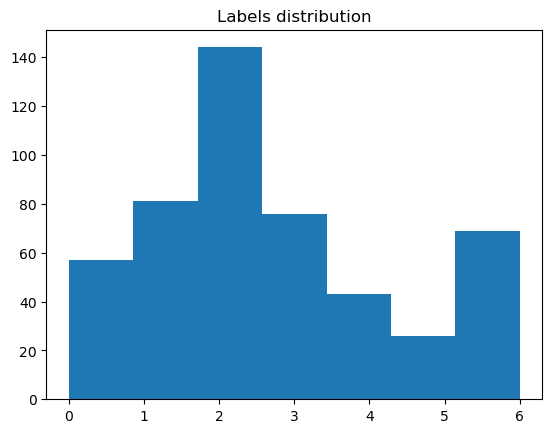

In [142]:
plt.hist(labels,bins=7);
plt.title("Labels distribution")
plt.show()

Might not need but in case

In [143]:
normalized_features = normalize(features, axis=0)

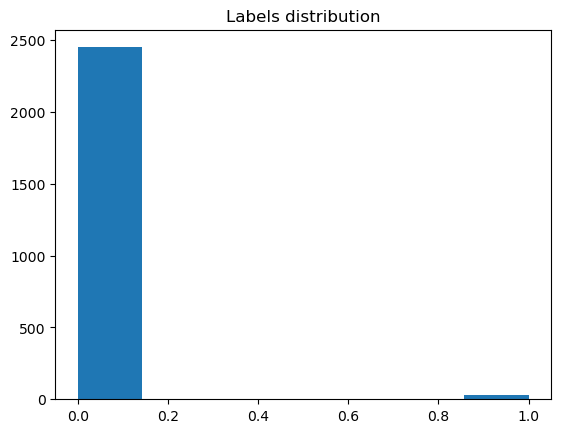

In [144]:
plt.hist(features[:,1],bins=7);
plt.title("Labels distribution")
plt.show()

In [145]:
num_unique_values = np.apply_along_axis(lambda x: len(np.unique(x)), axis=0, arr=features)
num_same_value_columns = np.sum(num_unique_values == 1)

print(f"Number of columns with the same value for all nodes: {num_same_value_columns}")

column_averages = np.mean(features, axis=0)
print("Averages of all columns:")
for idx, avg in enumerate(column_averages):
    print(f"Column {idx + 1}: {avg}")

Number of columns with the same value for all nodes: 5
Averages of all columns:
Column 1: 0.006048387096774193
Column 2: 0.012096774193548387
Column 3: 0.02620967741935484
Column 4: 0.025
Column 5: 0.06330645161290323
Column 6: 0.0024193548387096775
Column 7: 0.01129032258064516
Column 8: 0.0032258064516129032
Column 9: 0.011693548387096775
Column 10: 0.0024193548387096775
Column 11: 0.005241935483870968
Column 12: 0.0032258064516129032
Column 13: 0.010080645161290322
Column 14: 0.008064516129032258
Column 15: 0.004032258064516129
Column 16: 0.0036290322580645163
Column 17: 0.00564516129032258
Column 18: 0.0032258064516129032
Column 19: 0.0064516129032258064
Column 20: 0.21088709677419354
Column 21: 0.0012096774193548388
Column 22: 0.004435483870967742
Column 23: 0.0016129032258064516
Column 24: 0.008064516129032258
Column 25: 0.0012096774193548388
Column 26: 0.02661290322580645
Column 27: 0.02379032258064516
Column 28: 0.013306451612903225
Column 29: 0.0032258064516129032
Column 30: 0

In [146]:
max_value = np.max(features)
min_value = np.min(features)
print(max_value, min_value)

1 0


In [147]:
edge_index[1].dtype

torch.float32

# 3. Making the DATA object for training
- x: features
- edge_index: edge_index[0] (weight 1 for all edges)
- y: labels
- train_mask: training indices
- test_mask: testting indices

In [148]:
x = torch.tensor(features, dtype=torch.float)

In [149]:
# making the masks
train_val_indices = data_splits['idx_train']
test_indices = data_splits['idx_test']

train_val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
train_val_mask[train_val_indices] = 1
test_mask = torch.zeros(features.shape[0], dtype=torch.bool)
test_mask[test_indices] = 1

Making an extended labels tensor for easy training

In [150]:
labels_tensor = torch.zeros(features.shape[0], dtype=torch.int64)
labels_i = 0
for i in train_val_indices:
    labels_tensor[i] = labels[labels_i]
    labels_i += 1

labels_tensor

tensor([5, 0, 0,  ..., 0, 0, 0])

Creating a validation mask

In [151]:
def create_train_val_masks(train_val_mask, val_ratio):
    labeled_indices = train_val_mask.nonzero().view(-1)
    permuted_indices = torch.randperm(labeled_indices.size(0))
    
    shuffled_indices = labeled_indices[permuted_indices]
    
    num_val_nodes = int(val_ratio * len(labeled_indices))
    
    val_indices = shuffled_indices[permuted_indices[:num_val_nodes]]
    train_indices = shuffled_indices[permuted_indices[num_val_nodes:]]
    
    train_mask = torch.zeros(NODES, dtype=torch.bool)
    train_mask[train_indices] = 1
    val_mask = torch.zeros(NODES, dtype=torch.bool)
    val_mask[val_indices] = 1
    return train_mask, val_mask

val_ratio = 0.2
train_mask, val_mask = create_train_val_masks(train_val_mask, val_ratio)

In [152]:
labeled_indices = train_val_mask.nonzero().view(-1)
permuted_indices = torch.randperm(labeled_indices.size(0))

shuffled_indices = labeled_indices[permuted_indices]

val_ratio = 0.2
num_val_nodes = int(val_ratio * len(labeled_indices))

val_indices = shuffled_indices[permuted_indices[:num_val_nodes]]
train_indices = shuffled_indices[permuted_indices[num_val_nodes:]]

train_mask = torch.zeros(features.shape[0], dtype=torch.bool)
train_mask[train_indices] = 1
val_mask = torch.zeros(features.shape[0], dtype=torch.bool)
val_mask[val_indices] = 1

Now we have everything for the data object

In [153]:
data = Data(x=x, edge_index=edge_index[0], y=labels_tensor, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
data

Data(x=[2480, 1390], edge_index=[2, 10100], y=[2480], train_mask=[2480], val_mask=[2480], test_mask=[2480])

# 4. Constructing Model

In [154]:
class GCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super().__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden)
        self.conv2 = GCNConv(num_hidden, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

# 5. Training

In [155]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data = data.to(device)

In [156]:
model = GCN(num_node_features=data.x.shape[1], 
            num_hidden=16,
            num_classes=7
           ).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

model.train()
for epoch in range(200):
    optimizer.zero_grad()
    out = model(data)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    if epoch % 10 == 0:
        print('Epoch {0}: {1}'.format(epoch, loss.item()))

Epoch 0: 1.9280089139938354
Epoch 10: 0.8722324967384338
Epoch 20: 0.4308478534221649
Epoch 30: 0.2576611042022705
Epoch 40: 0.19107283651828766
Epoch 50: 0.14897595345973969
Epoch 60: 0.1337127685546875
Epoch 70: 0.12450424581766129
Epoch 80: 0.10627160221338272
Epoch 90: 0.11218834668397903
Epoch 100: 0.09315627068281174
Epoch 110: 0.076871857047081
Epoch 120: 0.09388235211372375
Epoch 130: 0.08624928444623947
Epoch 140: 0.08818143606185913
Epoch 150: 0.07626543939113617
Epoch 160: 0.07088776677846909
Epoch 170: 0.0653773844242096
Epoch 180: 0.07265171408653259
Epoch 190: 0.06569652259349823


In [157]:
model.eval()
pred = model(data).argmax(dim=1)

In [158]:
correct = (pred[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 1.0000


In [159]:
# examples_test = []
# for i, p in zip(data_splits['idx_train'], labels):
#     examples_test.append((i, p))
# examples_test.sort()
# examples_test
# exxx = [b for a, b in examples_test]
# torch.tensor(exxx, dtype=torch.int64)

In [160]:
test_preds = pred[data_splits['idx_test']].cpu()
test_preds

tensor([1, 3, 2,  ..., 4, 1, 3])

In [161]:
# np.savetxt('submission.txt', test_preds, fmt='%d')

# K-fold cross validation Training

In [332]:
NUM_FOLDS = 40
EPOCHS = 150

val_losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = GCN(num_node_features=data.x.shape[1], 
        num_hidden=16,
        num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

for fold in range(NUM_FOLDS):
    train_mask, val_mask = create_train_val_masks(train_val_mask, val_ratio)
    
    data = Data(x=x, edge_index=edge_index[0], y=labels_tensor, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    data = data.to(device)
    
    model.train()   
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # if epoch % 10 == 0:
        #     print('Epoch {0}: {1}'.format(epoch, loss.item()))
    

    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())
    
    print(f'Fold {fold + 1}: Validation Loss: {val_loss.item()}')

avg_val_loss = sum(val_losses) / len(val_losses)
print(f'Average Validation Loss: {avg_val_loss}')

Fold 1: Validation Loss: 1.0057224035263062
Fold 2: Validation Loss: 0.5164444446563721
Fold 3: Validation Loss: 0.313418984413147
Fold 4: Validation Loss: 0.3459124267101288
Fold 5: Validation Loss: 0.17201292514801025
Fold 6: Validation Loss: 0.21202312409877777
Fold 7: Validation Loss: 0.1220339983701706
Fold 8: Validation Loss: 0.1553184986114502
Fold 9: Validation Loss: 0.0859047994017601
Fold 10: Validation Loss: 0.11267568916082382
Fold 11: Validation Loss: 0.10535996407270432
Fold 12: Validation Loss: 0.09655585139989853
Fold 13: Validation Loss: 0.06864357739686966
Fold 14: Validation Loss: 0.07461297512054443
Fold 15: Validation Loss: 0.09457527846097946
Fold 16: Validation Loss: 0.10342460870742798
Fold 17: Validation Loss: 0.05757850036025047
Fold 18: Validation Loss: 0.06510622054338455
Fold 19: Validation Loss: 0.07243478298187256
Fold 20: Validation Loss: 0.058300845324993134
Fold 21: Validation Loss: 0.08474057167768478
Fold 22: Validation Loss: 0.07349130511283875
Fold

In [333]:
model.eval()
pred_Kfold = model(data).argmax(dim=1)

correct = (pred_Kfold[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

Accuracy: 1.0000


In [334]:
test_preds = pred_Kfold[test_indices].cpu()
test_preds

tensor([1, 3, 2,  ..., 4, 1, 3])

In [268]:
# np.savetxt('submission.txt', test_preds, fmt='%d')

In [269]:
with open('./submission.txt', 'r') as file:
    lines = file.readlines()

prev_sub = [int(line) for line in lines]

In [227]:
def compare(prev_sub, curr_pred, two_current=False):
    c = 0
    
    if two_current:
        for q, w in zip(prev_sub[test_indices], curr_pred[test_indices]):
            if q.item() != w.item():
                c += 1
        return c
    
    for q, w in zip(prev_sub, curr_pred[test_indices]):
        if q != w.item():
            c += 1
    return c

In [298]:
compare(prev_sub, pred_Kfold)

133

In [229]:
compare(prev_sub, pred)

136

In [200]:
compare(pred, pred_Kfold, two_current=True)

165

In [174]:
class EnhancedGCN(torch.nn.Module):
    def __init__(self, num_node_features, num_hidden, num_classes):
        super(EnhancedGCN, self).__init__()
        self.conv1 = GCNConv(num_node_features, num_hidden)
        self.bn1 = BatchNorm(num_hidden)
        self.conv2 = GCNConv(num_hidden, num_hidden)
        self.bn2 = BatchNorm(num_hidden)
        # Adding a third layer for increased model depth
        self.conv3 = GCNConv(num_hidden, num_classes)
        
        # Optional: Additional Linear Layer for complex transformations, if needed
        # self.lin = torch.nn.Linear(num_classes, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First GCN layer
        x = F.relu(self.bn1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training)
        
        # Second GCN layer with skip connection
        x_skip = x  # Storing previous layer's output for skip connection
        x = F.relu(self.bn2(self.conv2(x, edge_index)))
        x = F.dropout(x, p=0.5, training=self.training) + x_skip  # Skip connection
        
        # Third GCN layer
        x = self.conv3(x, edge_index)
        
        # Optional: Additional Linear transformation, if you uncomment the lin layer
        # x = self.lin(x)

        return F.log_softmax(x, dim=1)


In [323]:
NUM_FOLDS = 15
EPOCHS = 220

val_losses = []

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = EnhancedGCN(num_node_features=data.x.shape[1], 
        num_hidden=16,
        num_classes=7).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=5e-4)

for fold in range(NUM_FOLDS):
    train_mask, val_mask = create_train_val_masks(train_val_mask, val_ratio)
    
    data = Data(x=x, edge_index=edge_index[0], y=labels_tensor, train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
    data = data.to(device)
    
    model.train()   
    for epoch in range(EPOCHS):
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()
        # if epoch % 20 == 0:
        #     print('Epoch {0}: {1}'.format(epoch, loss.item()))
    

    model.eval()
    with torch.no_grad():
        val_out = model(data)
        val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
        val_losses.append(val_loss.item())
    
    print(f'Fold {fold + 1}: Validation Loss: {val_loss.item()}')

avg_val_loss = sum(val_losses) / len(val_losses)
print(f'Average Validation Loss: {avg_val_loss}')

model.eval()
pred_Kfold_new_model = model(data).argmax(dim=1)

correct = (pred_Kfold_new_model[data.train_mask] == data.y[data.train_mask]).sum()
acc = int(correct) / int(data.train_mask.sum())
print(f'Accuracy: {acc:.4f}')

test_preds = pred_Kfold_new_model[test_indices].cpu()
test_preds

Fold 1: Validation Loss: 0.9101932644844055
Fold 2: Validation Loss: 0.437178373336792
Fold 3: Validation Loss: 0.2455003708600998
Fold 4: Validation Loss: 0.15932124853134155
Fold 5: Validation Loss: 0.16271498799324036
Fold 6: Validation Loss: 0.07186872512102127
Fold 7: Validation Loss: 0.17625650763511658
Fold 8: Validation Loss: 0.08368512243032455
Fold 9: Validation Loss: 0.17171615362167358
Fold 10: Validation Loss: 0.15823954343795776
Fold 11: Validation Loss: 0.1610109508037567
Fold 12: Validation Loss: 0.050405487418174744
Fold 13: Validation Loss: 0.09280677139759064
Fold 14: Validation Loss: 0.18671010434627533
Fold 15: Validation Loss: 0.15897685289382935
Average Validation Loss: 0.21510563095410665
Accuracy: 1.0000


tensor([1, 3, 2,  ..., 4, 1, 3])

In [330]:
compare(pred_Kfold, pred_Kfold_new_model, two_current=True)

251

In [292]:
compare(prev_sub, pred_Kfold_new_model)

290

In [280]:
import numpy as np
import torch.optim as optim
from torch_geometric.data import Data

# Assuming your EnhancedGCN model, data preparation, and necessary imports are defined here

def train_and_evaluate(learning_rate, weight_decay):
    # Initialize your model and optimizer with given hyperparameters
    model = EnhancedGCN(num_node_features=data.x.shape[1], 
                        num_hidden=16, 
                        num_classes=7).to(device)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    
    for epoch in range(200):  # EPOCHS is assumed to be defined
        model.train()
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation phase
        model.eval()
        with torch.no_grad():
            val_out = model(data)
            val_loss = F.nll_loss(val_out[data.val_mask], data.y[data.val_mask])
            if val_loss < best_val_loss:
                best_val_loss = val_loss.item()

    return best_val_loss

# Define ranges for learning rate and weight decay
learning_rate_range = np.logspace(-4, 0, 100)  # 20 values from 1e-6 to 1e-0
weight_decay_range = [5e-4]

best_lr = None
best_wd = None
lowest_val_loss = float('inf')

results = []

# Loop over both learning rate and weight decay ranges
for lr in learning_rate_range:
    for wd in weight_decay_range:
        val_loss = train_and_evaluate(lr, wd)
        results.append((lr, wd, val_loss))
        print(f"LR: {lr:.1e}, WD: {wd:.1e}, Val Loss: {val_loss:.4f}")
        if val_loss < lowest_val_loss:
            best_lr = lr
            best_wd = wd
            lowest_val_loss = val_loss

print(f"Best LR: {best_lr:.1e}, Best WD: {best_wd:.1e}, Lowest Validation Loss: {lowest_val_loss:.4f}")

# Optional: Visualization code here
# You may need a 3D plot to visualize learning rate, weight decay, and validation loss together


LR: 1.0e-04, WD: 5.0e-04, Val Loss: 1.3164
LR: 1.1e-04, WD: 5.0e-04, Val Loss: 1.1070
LR: 1.2e-04, WD: 5.0e-04, Val Loss: 1.1608
LR: 1.3e-04, WD: 5.0e-04, Val Loss: 1.1580
LR: 1.5e-04, WD: 5.0e-04, Val Loss: 1.0250
LR: 1.6e-04, WD: 5.0e-04, Val Loss: 1.1864
LR: 1.7e-04, WD: 5.0e-04, Val Loss: 0.9428
LR: 1.9e-04, WD: 5.0e-04, Val Loss: 1.0116
LR: 2.1e-04, WD: 5.0e-04, Val Loss: 0.9847
LR: 2.3e-04, WD: 5.0e-04, Val Loss: 0.9401
LR: 2.5e-04, WD: 5.0e-04, Val Loss: 0.8791
LR: 2.8e-04, WD: 5.0e-04, Val Loss: 0.7936
LR: 3.1e-04, WD: 5.0e-04, Val Loss: 0.7801
LR: 3.4e-04, WD: 5.0e-04, Val Loss: 0.7933
LR: 3.7e-04, WD: 5.0e-04, Val Loss: 0.8107
LR: 4.0e-04, WD: 5.0e-04, Val Loss: 0.7788
LR: 4.4e-04, WD: 5.0e-04, Val Loss: 0.7268
LR: 4.9e-04, WD: 5.0e-04, Val Loss: 0.7215
LR: 5.3e-04, WD: 5.0e-04, Val Loss: 0.7169
LR: 5.9e-04, WD: 5.0e-04, Val Loss: 0.7713
LR: 6.4e-04, WD: 5.0e-04, Val Loss: 0.8423
LR: 7.1e-04, WD: 5.0e-04, Val Loss: 0.6822
LR: 7.7e-04, WD: 5.0e-04, Val Loss: 0.7792
LR: 8.5e-04

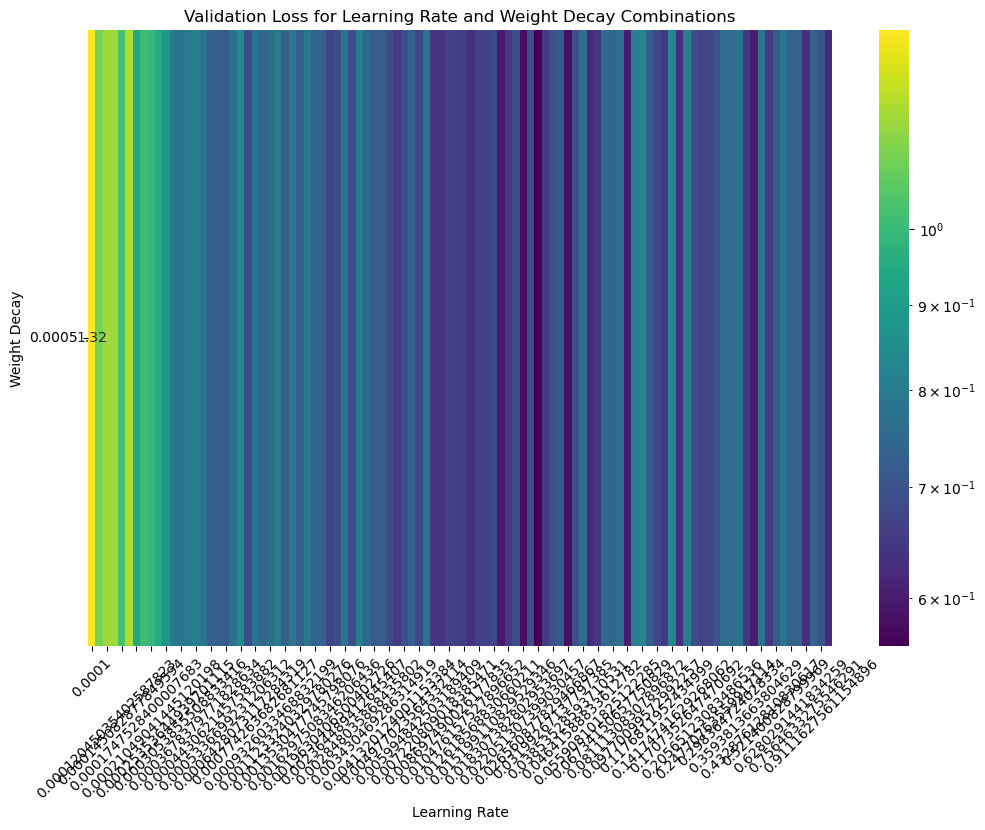

In [281]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming 'results' contains tuples of (learning_rate, weight_decay, val_loss)
df = pd.DataFrame(results, columns=['Learning Rate', 'Weight Decay', 'Validation Loss'])

# Use pivot_table instead of pivot
pivot_table = df.pivot_table(index='Weight Decay', columns='Learning Rate', values='Validation Loss')

# Now, create the heatmap
plt.figure(figsize=(12, 8))
# Note: Adjusting the color scale with 'norm' to show variations clearly
from matplotlib.colors import LogNorm
sns.heatmap(pivot_table, annot=True, fmt=".2f", cmap="viridis", norm=LogNorm())
plt.title('Validation Loss for Learning Rate and Weight Decay Combinations')
plt.xlabel('Learning Rate')
plt.ylabel('Weight Decay')

# Setting the tick labels to display the learning rate and weight decay in scientific notation
plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.show()


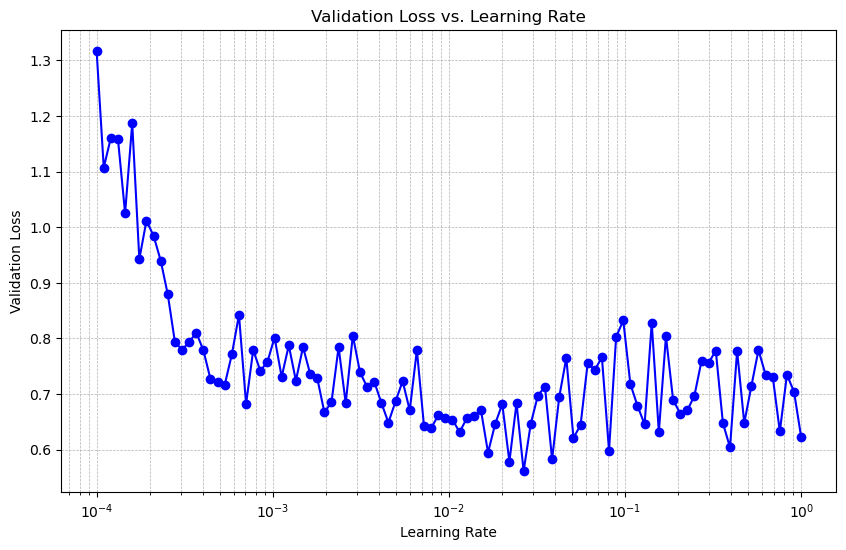

In [282]:
import matplotlib.pyplot as plt

# Extracting learning rates and their corresponding validation losses from the results
learning_rates, validation_losses = zip(*[(lr, val_loss) for lr, _, val_loss in results])

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(learning_rates, validation_losses, marker='o', linestyle='-', color='b')
plt.xscale('log')  # Since learning rates are on a log scale
plt.xlabel('Learning Rate')
plt.ylabel('Validation Loss')
plt.title('Validation Loss vs. Learning Rate')
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()
